# Citation network topic modeling
In this notebook, we'll implement topic modeling on the various categories in the desiccation tolerance citation network

In [1]:
import jsonlines
import networkx as nx
import sys
sys.path.append('../desiccation_network/conference_recommendation')
sys.path.append('../data/')
from openai_key import API_KEY
import utils
import pandas as pd
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance, KeyBERTInspired, PartOfSpeech, OpenAI
import openai
from ast import literal_eval
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from transformers.pipelines import pipeline
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import umap.plot
import sklearn

2024-03-15 09:46:18.186648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 09:46:20.520338: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/mnt/home/lotrecks/anaconda3/envs/graphs/lib/python3.10/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.re

## Read in data
For now, doing this for main result network only (ignoring unclassified other references).

In [2]:
with jsonlines.open('../data/wos_files/core_collection_destol_or_anhydro_FILTERED_MAIN_ONLY_with_ref_abstracts_05Jan2023.jsonl') as reader:
    data = []
    for obj in reader:
        data.append(obj)

In [3]:
class_graph = nx.read_graphml('../data/citation_network/core_collection_destol_or_anhydro_FILTERED_classified_network_06Jan2023_MANUALLY_VERIFIED.graphml')

Map classifications from the graph to the dataset with abstracts:

In [4]:
data_with_class = utils.map_classes_to_jsonl(class_graph, data, False, 'UID')

In [5]:
abstracts_and_classes = {'UID': [], 'abstract': [], 'study_system': [], 'year': []}
for paper in data_with_class:
    abstracts_and_classes['UID'].append(paper['UID'])
    abstracts_and_classes['abstract'].append(paper['abstract'])
    abstracts_and_classes['study_system'].append(paper['study_system'])
    abstracts_and_classes['year'].append(int(paper['year']))
abstracts = pd.DataFrame.from_dict(abstracts_and_classes, orient='columns').set_index('UID')
print(f'There are {len(abstracts)} abstracts in the dataset.')
abstracts.head()

There are 5564 abstracts in the dataset.


,abstract,study_system,year
UID,,,
WOS:A1990ET59600010,Four sorghum (Sorghum bicolor L. Moench) lines...,Plant,1990
WOS:000244317000009,Cynanchum komarovii is well adapted to hot and...,Plant,2007
WOS:000249421700004,Synergies between global change and biological...,Animal,2007
WOS:000251161900001,"Desiccation tolerance (DT), or the capacity to...",Plant,2007
WOS:000244031100003,Bean seed storage ability is of major interest...,Plant,2007


In [6]:
docs = abstracts.abstract.tolist()

## Model fitting

**Note:** The final code in this section reflects a lot of manual experimentation with different component models previously in this notebook. Here, we've simplified this to one function that we run twice, once for the MMR representation model, and once for the OpenAI representation model, which is the code for the data we've included in the paper. We'd just like to point out in case anyone would like to perform a similar analysis that there is more manual experimentation that should be done to see what component models and parameters work best for your use case; we highly recommend the tutorials embedded in the [BERTopic documentation](https://maartengr.github.io/BERTopic/index.html) for a detailed reference.

There are several steps in the model fitting process:
1. Defining component models
    1. [SentenceTransformer](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#sentence-transformers)
    2. [Dimensionality reduction model](https://maartengr.github.io/BERTopic/getting_started/dim_reduction/dim_reduction.html)
    3. [Clustering model](https://maartengr.github.io/BERTopic/getting_started/clustering/clustering.html)
    4. [Vectorizer model](https://maartengr.github.io/BERTopic/getting_started/vectorizers/vectorizers.html)
2. Pre-calculation of embeddings
3. Initial fitting
4. Outlier reduction

Here, we'll define a function to perform this entire process so that we can easily change representation models.

In [7]:
def fit_reduce_model(rep_model, docs):
    """
    Defines all component models internally besides the representation model, which is the only one that changes.
    Pre-calculates embeddings, fits model, and performs outlier reduction.

    parameters:
        rep_model, class instance from bertopic.representation: representation model
        docs, list of str: documents to model

    returns:
        topic_model, BERTopic model: fitted model with outliers reduced
    """
    # Define all component models
    print('Defining component models...')
    sentence_model = SentenceTransformer('allenai/scibert_scivocab_cased')
    umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
    ## Using default HDBSCAN model, no definition needed
    vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3), min_df=10)
    representation_model=rep_model
    
    # Pre-calculate embeddings
    print('Calculating embeddings...')
    embeddings = sentence_model.encode(docs, show_progress_bar=True)
    # We reduce our embeddings to 2D as it will allows us to quickly iterate later on
    reduced_embeddings = umap_model.fit_transform(embeddings)
    
    # Fit the model
    print('Fitting model...')
    topic_model = BERTopic(embedding_model=sentence_model, umap_model=umap_model, representation_model=representation_model, vectorizer_model=vectorizer_model)
    topics, probs = topic_model.fit_transform(docs, embeddings)
    
    # Reduce outliers
    print('Reducing outliers...')
    new_topics = topic_model.reduce_outliers(docs, topics, strategy='embeddings', threshold=0.1) # This method ends up reducing all outliers even with this threshold
    topic_model.update_topics(docs, topics=new_topics, vectorizer_model=vectorizer_model, representation_model=representation_model)
    
    return topic_model

In [8]:
# Define MMR model and get its corresponding topic model
mmr_rep_model = MaximalMarginalRelevance(diversity=0.3)
mmr_model = fit_reduce_model(mmr_rep_model, docs)

Defining component models...


No sentence-transformers model found with name /mnt/home/lotrecks/.cache/torch/sentence_transformers/allenai_scibert_scivocab_cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /mnt/home/lotrecks/.cache/torch/sentence_transformers/allenai_scibert_scivocab_cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be 

Calculating embeddings...


Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Fitting model...
Reducing outliers...


2024-03-15 09:50:12,262 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [9]:
# Define OpenAI model and get its corresponding topic model
client = openai.OpenAI(api_key=API_KEY)
openai_rep_model = OpenAI(client, "gpt-3.5-turbo", chat=True)
openai_model = fit_reduce_model(openai_rep_model, docs)

Defining component models...


No sentence-transformers model found with name /mnt/home/lotrecks/.cache/torch/sentence_transformers/allenai_scibert_scivocab_cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /mnt/home/lotrecks/.cache/torch/sentence_transformers/allenai_scibert_scivocab_cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be 

Calculating embeddings...


Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Fitting model...
Reducing outliers...


2024-03-15 09:52:59,828 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


## Summarize topic information
We want to see what proportion of each topic is made up of each class, to see if there are some that are more dominated by one group or another. We would expect to see the same proportions as the overall graph if there were no difference in topics in each discipline, so major departures from those splits are what we're looking for. We'll make a supplemental table as well as figures, and also compare the OpenAI representations to MMR representations. We can do this since we used all of the same other component models and random seeds, so the underlying topic clusters are the same.

In [127]:
def make_table(mmr_model, openai_model, abstracts):
    """
    Make a table with both types of representations and kingdom memberships.
    """
    # Get docs
    docs = abstracts.abstract.tolist()
    
    # Get topic info
    topic_dfs = {}
    for model_name, model in {'MMR': mmr_model, 'OpenAI': openai_model}.items():
        doc_topics = model.get_document_info(docs)
        doc_topics['UID'] = abstracts.index
        doc_topics['study_system'] = abstracts['study_system'].values.tolist()
        topic_dfs[model_name] = doc_topics
    
    # Assert that the docs in ecah cluster are the same
    assert (topic_dfs['MMR'][['Topic', 'UID']].to_dict() == 
            topic_dfs['OpenAI'][['Topic', 'UID']].to_dict())
    
    # Merge dfs 
    topic_dfs = {k: v.drop(columns=['Representative_Docs', 'Top_n_words'])
                 for k, v in topic_dfs.items()}
    combined_topic_df = topic_dfs['MMR'].merge(topic_dfs['OpenAI'],
                                    on=['Document', 'Topic', 'Probability',
                                        'Representative_document', 'UID', 'study_system'],
                                    how='outer', suffixes=('_MMR', '_OpenAI'))
    
    # Make sure merge worked as expected
    assert (combined_topic_df.shape[0] == topic_dfs['MMR'].shape[0]) and (
        combined_topic_df.shape[0] == topic_dfs['OpenAI'].shape[0])
    
    # Turn into a table with UIDs in a list and kingdoms by percentages
    table = defaultdict(list)
    for topic in sorted(combined_topic_df.Topic.unique()):
        topic_subset = combined_topic_df[combined_topic_df['Topic'] == topic]
        table['topic_num'].append(topic)
        table['num_docs'].append(len(topic_subset))
        table['uids'].append(topic_subset.UID.tolist())
        kings = topic_subset.study_system.tolist()
        for king in ['Fungi', 'Animal', 'Plant', 'Microbe']:
            table[king].append(kings.count(king)/len(topic_subset))
        king_sum = sum([table[king][-1] for king in ['Fungi', 'Animal', 'Plant', 'Microbe']])
        table['mmr_rep'].append(topic_subset.Representation_MMR.str.join(' | ').unique()[0])
        table['openai_rep'].append(topic_subset.Representation_OpenAI.str.join('').unique()[0])
    table_df = pd.DataFrame(table)
    
    return table_df

In [128]:
topic_reps = make_table(mmr_model, openai_model, abstracts)
topic_reps.head()

,topic_num,num_docs,uids,Fungi,Animal,Plant,Microbe,mmr_rep,openai_rep
0,0,589,"[WOS:000244031100003, WOS:000259861800008, WOS...",0.001698,0.018676,0.974533,0.005093,moisture | moisture content | desiccation | wa...,Seed Germination and Desiccation Tolerance in ...
1,1,491,"[WOS:000248584500010, WOS:000797063100001, WOS...",0.018330,0.189409,0.651731,0.140530,mechanisms | review | stress | desiccation | s...,Understanding Mechanisms of Desiccation Tolera...
2,2,227,"[WOS:000252298000025, WOS:A1997BH23T00051, WOS...",0.004405,0.044053,0.929515,0.022026,somatic embryos | medium | cryopreservation | ...,Regulatory mechanisms of somatic embryo develo...
3,3,272,"[WOS:000244317000009, WOS:000256477200013, WOS...",0.011029,0.033088,0.904412,0.051471,desiccation | water | activity | resurrection ...,Photosynthetic Adaptations to Desiccation and ...
4,4,221,"[WOS:000243462300012, WOS:000434054800007, WOS...",0.036199,0.398190,0.208145,0.357466,tardigrades | anhydrobiosis | strains | anhydr...,Radiation Tolerance in Anhydrobiotic Species


In [129]:
topic_reps.to_csv('../data/citation_network/topic_modeling_output_MMR_and_OpenAI.csv', index=False)

## Visualize class distribution in topic clusters

In [135]:
bars_df = topic_reps[['topic_num', 'Plant', 'Animal', 'Fungi', 'Microbe']].set_index('topic_num').T
bars_df = bars_df.sort_values(by='Plant', axis=1)

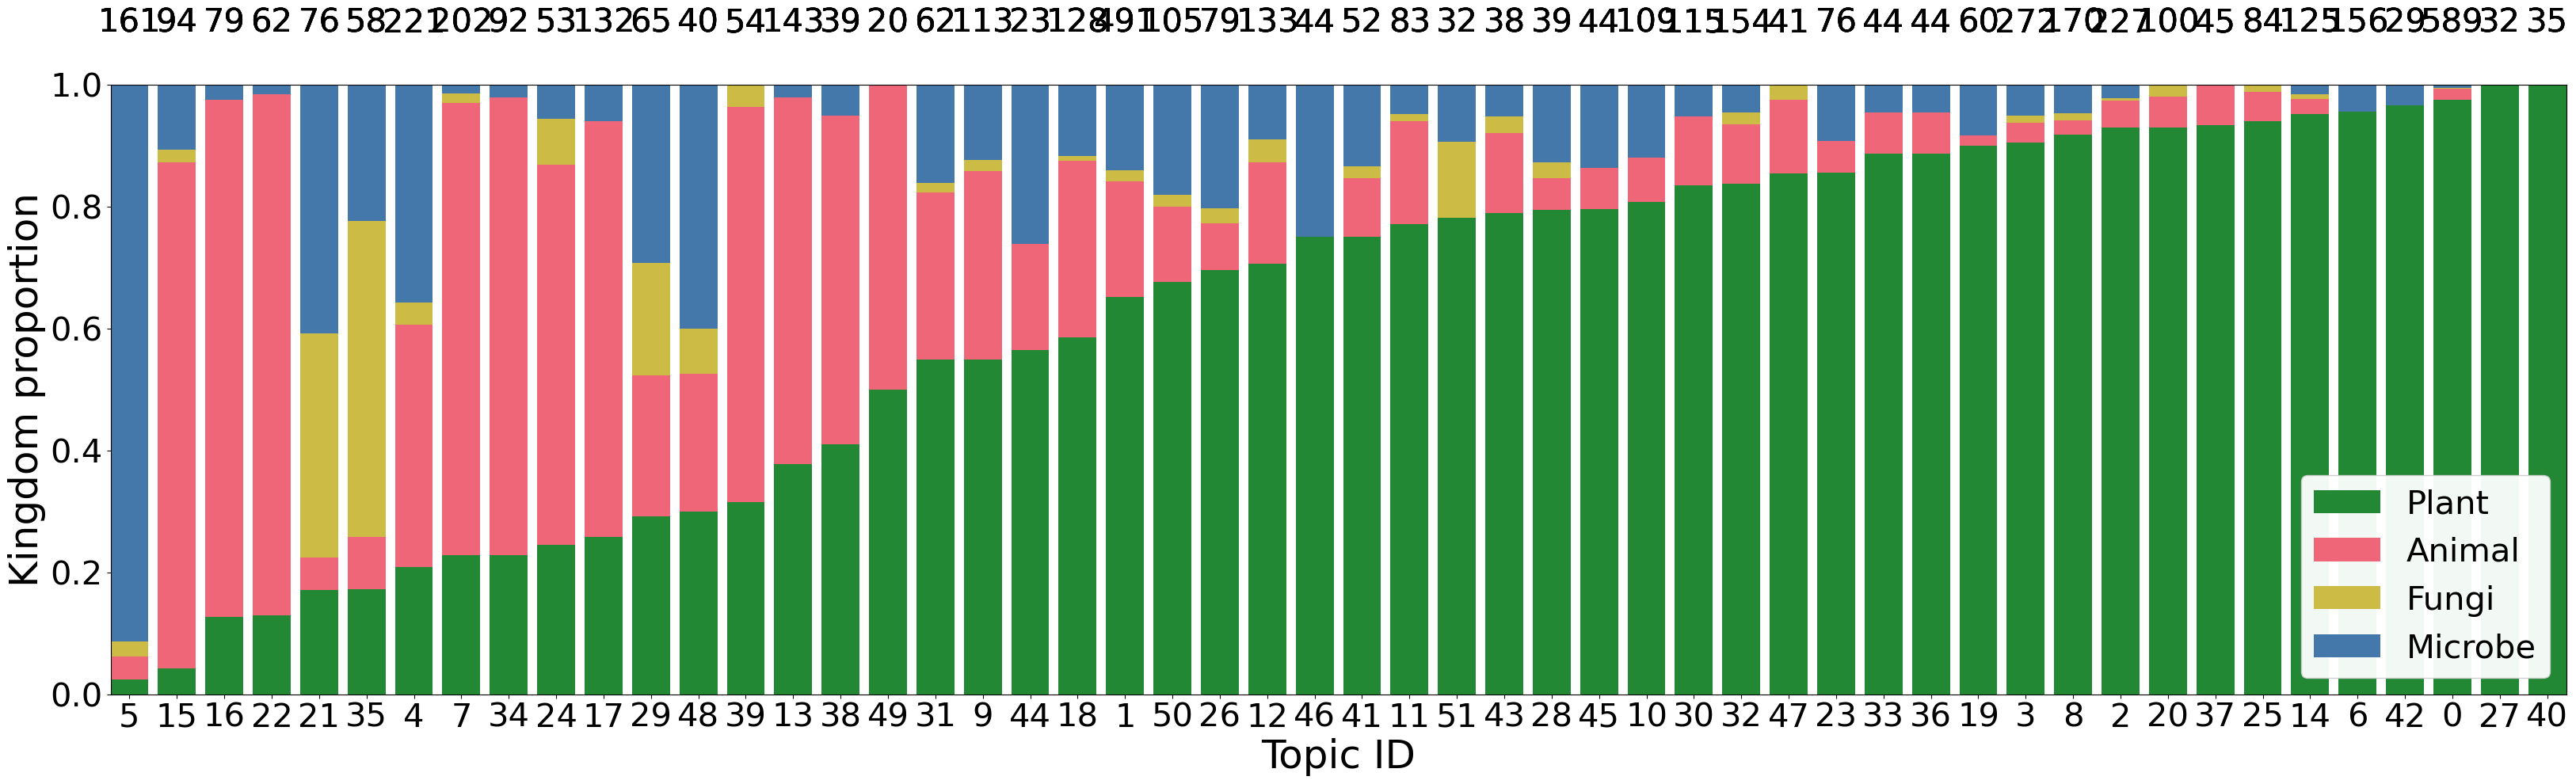

In [200]:
colors = {'Plant': '#228833', 'Animal':'#EE6677', 'Microbe': '#4477AA', 'Fungi':'#CCBB44'}
fig, ax = plt.subplots(figsize=(40,10))
bottom = np.zeros(bars_df.shape[1])

for system in bars_df.index:
    p = ax.bar(bars_df.columns.astype(str), bars_df.loc[system], color=colors[system], label=system, bottom=bottom)
    bottom += bars_df.loc[system]

xloc_to_xlab = {txt.get_unitless_position()[0]: txt.get_text() for txt in plt.gca().get_xticklabels()}
for i, p in enumerate(ax.patches):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    to_label = x + 0.5*width
    topic = xloc_to_xlab[to_label]
    label = topic_reps.loc[topic_reps['topic_num'] == int(topic), 'num_docs'].values[0]
    ax.text(x+width/2, 
            1.1, 
            '{}'.format(label), 
            horizontalalignment='center', 
            verticalalignment='center',
            fontsize=30)
#     rect = plt.Rectangle((x - width/2,1.07), width=len(str(label))*0.5, height=0.075,
#                          transform=ax.get_xaxis_transform(), zorder=3,
#                          fill=False, edgecolor='black', clip_on=False)
#     ax.add_patch(rect)
#     if i == 1:
#         break
plt.margins(x=0, tight=True)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('Topic ID', fontsize=36)
plt.ylabel('Kingdom proportion', fontsize=36)
plt.legend(fontsize=30, loc='lower right', framealpha=0.95)

plt.savefig('../data/citation_network/figures/topic_admixture.pdf', format='pdf', bbox_inches='tight', dpi=600)

## Hierarchical topic modeling
Another way we can look at the trends in these documents is by [hierarchical topic modeling](https://maartengr.github.io/BERTopic/getting_started/hierarchicaltopics/hierarchicaltopics.html). This groups topics according to whether there is some super-topic that could consume multiple sub-topics. Let's take a look:

In [194]:
hierarchical_topics = mmr_model.hierarchical_topics(docs)

100%|██████████| 51/51 [00:01<00:00, 28.11it/s]


In [197]:
# Save for labeling figure in post-processing since visualization function is inaccessible
hierarchical_topics.to_csv('../data/topic_models/hierarchical_topics_15Mar2024.csv', index=False)

In [199]:
fig = mmr_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
fig.show()
fig.write_image('../data/citation_network/figures/hierarchical_figure_default_aesthetics.pdf')